# March Machine Learning Mania 2023
## Forecast the 2023 NCAA Basketball Tournaments

Each season there are thousands of NCAA basketball games played between Division I college basketball teams, culminating in March Madness®, the 68-team national championship that starts in the middle of March.

The tournament teams include champions from 32 Division I conferences and 36 teams which are awarded at-large berths (selected by a committee). Teams are placed in four regions and given a seed between 1 and 16 within the region. The first week starts with eight teams competing in the First Four, with the four winners joining 60 teams to compete in the First and Second Rounds.

Sixteen winners advance to the second weekend to compete in the Regional Semifinals and Finals, also known as the Sweet Sixteen and Elite Eight, respectively, for the number of participants in the round. Four teams then advance to the third weekend for the National Semifinals and National Championship, collectively referred to as the Final Four. The winning team is crowned National Champion. 

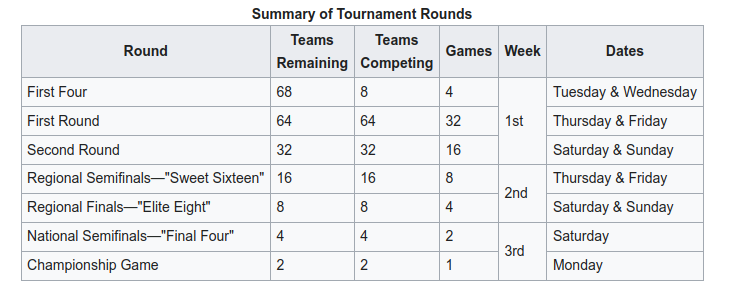

In [2]:
import numpy as np
import pandas as pd

### Data exploration

Prefixes:

* M_ - men's league
* W_ - women's league

In [6]:
# tourney data
M_tourney = pd.read_csv('data/MNCAATourneyDetailedResults.csv')
W_tourney = pd.read_csv('data/WNCAATourneyDetailedResults.csv')
# tourney seeds
M_seeds = pd.read_csv('data/MNCAATourneySeeds.csv')
W_seeds = pd.read_csv('data/WNCAATourneySeeds.csv')
# regular season data
M_regular = pd.read_csv('data/MRegularSeasonDetailedResults.csv')
W_regular = pd.read_csv('data/WRegularSeasonDetailedResults.csv')


In [9]:
print(f"M_regular shape: {M_regular.shape}")
print(f"M_tourney shape: {M_tourney.shape}")
print(f"M_seeds shape: {M_seeds.shape}")
print(f"W_regular shape: {W_regular.shape}")
print(f"W_tourney shape: {W_tourney.shape}")
print(f"W_seeds shape: {W_seeds.shape}")

M_regular shape: (107634, 34)
M_tourney shape: (1248, 34)
M_seeds shape: (2490, 3)
W_regular shape: (70783, 34)
W_tourney shape: (760, 34)
W_seeds shape: (1608, 3)


In [12]:
M_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [13]:
M_regular.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [15]:
M_tourney.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [20]:
print(all(M_tourney.columns == M_regular.columns))
print(all(W_regular.columns == W_tourney.columns))
print(all(M_regular.columns == W_regular.columns))

True
True
True


In [21]:
M_regular.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

Same columns for tourney and regular datasets. Column names explanation (W or L prefixes refer to winning or losing team) for winning team:

* WFGM - field goals made
* WFGA - field goals attempted
* WFGM3 - three pointers made 
* WFGA3 - three pointers attempted
* WFTM - free throws made
* WFTA - free throws attempted
* WOR - offensive rebounds
* WDR - defensive rebounds
* WAst - assists
* WTO - turnovers committed
* WStl - steals
* WBlk - blocks
* WPF - personal fouls committed

WLoc column says if the winning team was playing, away/at home/neutral (eg. tournaments)

In [25]:
M_tourney["WLoc"].unique() # in tourney every team plays in neutral court

array(['N'], dtype=object)

In [27]:
M_regular["WLoc"].value_counts() # in regular season most games are won on home court

H    63368
A    33239
N    11027
Name: WLoc, dtype: int64

In [30]:
W_seeds.tail()

,Season,Seed,TeamID
1603,2023,Z12,3405
1604,2023,Z13,3387
1605,2023,Z14,3241
1606,2023,Z15,3436
1607,2023,Z16,3151


We have information about the 2023 tournament seeding.

### Data preparation

* Change from W-team and L-team to T1 and T2 where T1_TeamID < T2_TeamID
* add win = 1 when T1 won over T2 and 0 when T1 lost
* add seeding
* add conferences (?)
* add massey (?)

### Feature engineering

* means
* rolling ratios
* ...

### Models

### Submisson